<a><img src="https://cdn.iconscout.com/icon/free/png-256/data-science-46-1170621.png" width="100" align="center"></a>

<h1><center>Applied Data Science Capstone</center></h1>
<h3><center>Segmenting and Clustering Neighborhoods in Kuwait</center></h3>

Welcome to my final project notebook. This notebook will delve deep into the neighborhoods of Kuwait and, using the Foursquare API, find venues in each neighborhood. After gathering all of the required data, analysis will follow to help cluster the different neighborhoods and gain insight into which areas are perfect for opening a new business. In addition, it will help suggest the best businesses to open in those areas.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3>

0. [Preface](#0)
1. [Gathering Data](#1)
2. [Get Latitude and Longitude](#2)
3. [Create a Map of Kuwait with Neighborhoods Superimposed](#3)
4. [Lets Do Some Analysis](#4)
5. [Data Wrangling](#5)
6. [Cluster the Neighborhoods](#6)
7. [Lets Visualize the Clusters](#7)
8. [Gaining Insight](#8)
9. [Results](#9)
10. [Discussion & Recommendations](#10)
11. [Conclusion](#11)
</font>
</div>

## 0. Preface

<h3>0. 1. Introduction</h3>

Welcome to my final project notebook. This notebook will delve deep into the neighborhoods of Kuwait and, using the Foursquare API, find venues in each neighborhood. After gathering all of the required data, analysis will follow to help cluster the different neighborhoods and gain insight into which areas are perfect for opening a new business. In addition, it will help suggest the best businesses to open in those areas.

<h3>0. 2. Business Problem</h3>

A client would like to open a new business, however they do not know what kind of business they would like to open, let alone where to open it. In this project, I will determine the optimal areas in Kuwait to open a business, as well as the perfect business for that area.

<h3>0. 3. Data</h3>

In order to answer the business question set forth in the previous notebook, we will be gathering data from a few sources. The first source will be Wikipedia. From Wikipedia, we will gather the areas of Kuwait. Next, using Google Maps' API, we will collect the approximate coordinates of each area. With the coordinates and area names collected, we will next be using the Foursquare API to collect venue information for each area, within a designated radius. The venue data collected from Foursquare will then be used to determine the top venues in each area. 

Once the venue information is gathered, the next step will be to cluster areas in Kuwait based on venues categories. This information will allow us to cluster customers in each area before moving on to identify areas within the clusters which are prime candidates for a new venue, as well as identifying which specific venues would be the most lucrative.

## 1. Gathering Data
<a id="1"></a>

<h3>1. 1. Import Data</h3>

<h4>1. 1. 1. Import Libraries</h4>

In [305]:
#Install dependencies if needed
# uncomment the below line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge geopy --yes
# uncomment the below line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install bs4

#Part 1: Scraping data
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import ssl
from bs4 import BeautifulSoup
import re

#Part 2: Data Analysis
import numpy as np
import pandas as pd
import json
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import requests
from sklearn.metrics import silhouette_score

<h4>1. 1. 2. Create SSL</h4>

In [19]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

<h4>1. 1. 3. Set Up Handler</h4>

In [20]:
url = "https://en.wikipedia.org/wiki/Areas_of_Kuwait"
fhand = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(fhand, 'lxml')

<h4>1. 1. 4. Populate Table</h4>

In [21]:
df = pd.DataFrame()

In [22]:
table_1 = soup.find_all('table')[1]
table_2 = soup.find_all('table')[2]
table_3 = soup.find_all('table')[3]
table_4 = soup.find_all('table')[4]
table_5 = soup.find_all('table')[5]

df_1 = pd.read_html(str(table_1))
df_2 = pd.read_html(str(table_2))
df_3 = pd.read_html(str(table_3))
df_4 = pd.read_html(str(table_4))
df_5 = pd.read_html(str(table_5))

df = pd.concat([df_1[0], df_2[0], df_3[0], df_4[0], df_5[0]], axis=0)

C:\Users\deez\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [23]:
df.shape

(84, 6)

In [25]:
df_kw = df.copy()

<h3>1. 2. Clean the DataFrame</h3>

<h4>1. 2. 1. Select only Area column</h4>

In [26]:
df_kw.reset_index(drop=True, inplace=True)
df_kw = df_kw[['English']]
df_kw.rename(columns={'English':'Area'}, inplace=True)
df_kw.head()

,Area
0,Kuwait City
1,Dasmān
2,Sharq
3,Mirgāb
4,Jibla


<h4>1. 2. 2. Drop any NaN calues</h4>

In [27]:
df_kw.dropna(axis=0, inplace=True)
df_kw.shape

(81, 1)

<h4>1. 2. 3. Add Abu Hassaniya</h4>

In [28]:
df_kw.loc[81] = 'Abu Hassaniya'

<h4>1. 2. 4. Locate all cells with word suburb</h4>

In [29]:
suburbs = df_kw[df_kw['Area'].str.contains("suburb")].index

<h4>1. 2. 5. Get rid of word suburb and fix errors</h4>

In [30]:
for i in suburbs:
    df_kw['Area'].iloc[i] = df_kw['Area'].iloc[i][:-7]

<h4>1. 2. 6. Change wrong area names</h4>

In [31]:
names = ['Ghirnata', "Bi'di'", 'Nigra', 'Aqila', 'Zuhar']
names_in = [25, 38, 39, 56, 57]

In [32]:
for i in names_in:
    print(df_kw['Area'].iloc[i])
    new_name = input('New name: ')
    df_kw['Area'].iloc[i] = new_name

Ghirnata
New name: Granada
Bi'di'
New name: Bidaa
Nigra
New name: Nuqra
Aqila
New name: Egaila
Zuhar
New name: Dahar


## 2. Get Latitude and Longitude

<a id="2"></a>

<h3>2. 1. Google Maps API</h3>

<h4>2. 1. 1. Define API credentials</h4>

The __credentials__ are hidden here
<!---
#Google Maps
api_key = 'XXXXXXX'
--->

<h4>2. 1. 2. Define function to call Google API</h4>

In [37]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

<h4>2. 1. 3. Make call and retreive latitude, longitude</h4>

In [38]:
latitudes = []
longitudes = []
i=0

# loop until you get all the coordinates
while i < len(df_kw):
    address = df_kw['Area'].iloc[i] + ', Kuwait'
    g = get_coordinates(api_key, address)
    latitudes.append(g[0])
    longitudes.append(g[1])
    print(' . ', end='')
    i += 1
print('Done!')

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . Done!


<h3>2. 2. Add lat, long to dataframe</h3>

<h4>2. 2. 1. Append lists</h4>

In [39]:
df_kw['Latitude'] = latitudes
df_kw['Longitude'] = longitudes
df_kw.head()

,Area,Latitude,Longitude
0,Kuwait City,29.375859,47.977405
1,Dasmān,29.387804,47.999790
2,Sharq,29.382323,47.988644
3,Mirgāb,29.366138,47.983692
4,Jibla,29.369934,47.968836


<h3>2. 3. Check for any missing values</h3>

<h4>2. 3. 1. Script to count number of NaN</h4>

In [40]:
count = 0
for i, v in enumerate(df_kw['Latitude']):
    if v == None:
        count += 1
print('There are {} missing values'.format(count))

There are 0 missing values


<h4>2. 3. 2. Export the dataframe...</h4>

In [41]:
df_kw.to_csv('df_kw.csv')

<h4>2. 3. 3. ...Import the dataframe if continuing later</h4>

In [ ]:
df_kw = pd.read_csv('df_kw.csv')

## 3. Create a Map of Kuwait with Neighborhoods Superimposed

<a id="3"></a>

<h3>3. 1. Get Latitude and Longitude of Kuwait City</h3>

<h4>3. 1. 1. Select Area for centering</h4>

In [42]:
address = 'Al Ahmadi, Kuwait'
g = get_coordinates(api_key, address)
latitude = g[0]
longitude = g[1]
print('The coordinates of {} are: {}, {}'.format(address, latitude, longitude))

The coordinates of Al Ahmadi, Kuwait are: 29.0853759, 48.0654706


<h3>3. 2. Generate Map</h3>

<h4>3. 2. 1. Generate map centered around the above coordinates</h4>

In [322]:
# create map of Kuwait using latitude and longitude values
map_kuwait = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for area, lat, lng in zip(df_kw['Area'], df_kw['Latitude'], df_kw['Longitude']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kuwait)  

map_kuwait

## 4. Lets Do Some Analysis
<a id="4"></a>

<h3>4. 1. Foursquare API</h3>

<h4>4. 1. 1. Define Foursquare Credentials</h4>

The __credentials__ are hidden here

<!---
CLIENT_ID = 'XXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXX' 
VERSION = '20180605' # Foursquare API version
--->
<!---
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
--->

<h3>4. 2. Explore Each Neighborhood</h3>

<h4>4. 2. 1. Define get venues function</h4>

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    radius = 700
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' . ', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Lat', 
                  'Area Long', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Long', 
                  'Category']
    print('done!')
    return(nearby_venues)

<h4>4. 2. 2. Get the venues</h4>

In [49]:
kuwait_venues = getNearbyVenues(names = df_kw['Area'], latitudes = df_kw['Latitude'], longitudes = df_kw['Longitude'])

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . done!


<h4>4. 2. 3. Save the dataframe to continue later...</h4>

In [50]:
kuwait_venues.to_csv('kuwait_venues.csv')

<h4>4. 2. 4. ...Import the Dataframe if continuing later</h4>

In [51]:
kuwait_venues = pd.read_csv('kuwait_venues.csv')

## 5. Data Wrangling
<a id="5"></a>

<h3>5. 1. Foursquare returned information</h3>

<h4>5. 1. 1. Lets check the size of the returned dataframe</h4>

In [56]:
kuwait_venues.head()

,Unnamed: 0,Area,Area Lat,Area Long,Venue,Venue Lat,Venue Long,Category
0,0,Kuwait City,29.375859,47.977405,Concrete,29.375199,47.977508,Breakfast Spot
1,1,Kuwait City,29.375859,47.977405,Pick Yo (بك يو),29.375684,47.977405,Frozen Yogurt Shop
2,2,Kuwait City,29.375859,47.977405,HABRA,29.376388,47.977048,Steakhouse
3,3,Kuwait City,29.375859,47.977405,Tobys Estate (توبيس إستيت),29.375201,47.978188,Café
4,4,Kuwait City,29.375859,47.977405,CAF cafe,29.376773,47.978062,Café


<h4>5. 1. 2. Clean it up a bit</h4>

In [57]:
kuwait_venues.drop(['Unnamed: 0'], axis=1, inplace=True)

In [58]:
print(kuwait_venues.shape)
kuwait_venues.head()

(2524, 7)


,Area,Area Lat,Area Long,Venue,Venue Lat,Venue Long,Category
0,Kuwait City,29.375859,47.977405,Concrete,29.375199,47.977508,Breakfast Spot
1,Kuwait City,29.375859,47.977405,Pick Yo (بك يو),29.375684,47.977405,Frozen Yogurt Shop
2,Kuwait City,29.375859,47.977405,HABRA,29.376388,47.977048,Steakhouse
3,Kuwait City,29.375859,47.977405,Tobys Estate (توبيس إستيت),29.375201,47.978188,Café
4,Kuwait City,29.375859,47.977405,CAF cafe,29.376773,47.978062,Café


<h4>5. 1. 3. How many venues were returned for each neighborhood</h4>

In [59]:
kuwait_venues.groupby('Area').count()

,Area Lat,Area Long,Venue,Venue Lat,Venue Long,Category
Area,,,,,,
Abdullah Port,1,1,1,1,1,1
Abdullah as-Salim,36,36,36,36,36,36
Abu 'Fteira,9,9,9,9,9,9
Abu Hassaniya,21,21,21,21,21,21
Abu Hulaifa,17,17,17,17,17,17
Adiliya,35,35,35,35,35,35
Adān,11,11,11,11,11,11
Agricultural Wafra,5,5,5,5,5,5
Ahmadi,13,13,13,13,13,13


<h4>5. 1. 4. ...And how many unique categories</h4>

In [60]:
print('There are {} uniques categories.'.format(len(kuwait_venues['Category'].unique())))

There are 278 uniques categories.


<h3>5. 2. Analyze Each Neighborhood</h3>

<h4>5. 2. 1. Prep data for EDA</h4>

In [61]:
# one hot encoding
kuwait_onehot = pd.get_dummies(kuwait_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kuwait_onehot['Area'] = kuwait_venues['Area'] 

# move neighborhood column to the first column
fixed_columns = [kuwait_onehot.columns[-1]] + list(kuwait_onehot.columns[:-1])
kuwait_onehot = kuwait_onehot[fixed_columns]

In [62]:
kuwait_onehot.shape

(2524, 279)

<h4>5. 2. 2. Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category</h4>

In [63]:
kuwait_grouped = kuwait_onehot.groupby('Area').mean().reset_index()

In [64]:
kuwait_grouped.shape

(81, 279)

In [65]:
kuwait_grouped.head()

,Area,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Watch Shop,Water Park,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,Abdullah Port,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Abdullah as-Salim,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0
2,Abu 'Fteira,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Abu Hassaniya,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Abu Hulaifa,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


<h4>5. 2. 3. Function to sort venues in descending order</h4>

In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<h3>5. 3. Create dataframe and display top 10 venues per neighborhood</h3>

In [67]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Area'] = kuwait_grouped['Area']

for ind in np.arange(kuwait_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kuwait_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abdullah Port,Harbor / Marina,Dog Run,Donut Shop,Dry Cleaner,Egyptian Restaurant,Electronics Store,Event Service,Falafel Restaurant,Farm,Zoo Exhibit
1,Abdullah as-Salim,American Restaurant,Coffee Shop,Juice Bar,Cafeteria,Pizza Place,Grocery Store,Salon / Barbershop,Camera Store,Café,Dessert Shop
2,Abu 'Fteira,Plaza,Dessert Shop,Cafeteria,Restaurant,Fried Chicken Joint,Caribbean Restaurant,Supermarket,Middle Eastern Restaurant,Beach,Farmers Market
3,Abu Hassaniya,Café,Beach,Japanese Curry Restaurant,Middle Eastern Restaurant,Farm,Health Food Store,Hotel,Cupcake Shop,Coffee Shop,Boat or Ferry
4,Abu Hulaifa,Soccer Stadium,Dessert Shop,Soccer Field,Café,Arts & Crafts Store,Mexican Restaurant,Lounge,Burger Joint,Asian Restaurant,Grocery Store


## 6. Cluster the Neighborhoods
<a id="6"></a>

<h3>6. 1. Grab a fresh copy of the dataframe</h3>

In [68]:
kuwait_grouped_clustering = kuwait_grouped.drop('Area', 1)

<h4>6. 1. 1. Find optimum k</h4>

The best k is [8] with a silhouette score of [0.72053775]


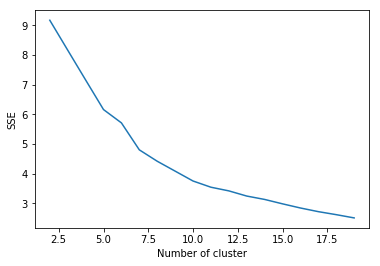

In [69]:
sse = {}
list_1 = []
list_2 = []
sil = pd.DataFrame()

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=0).fit(kuwait_grouped_clustering)
    kuwait_grouped_clustering["Clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    label = kmeans.labels_
    sil_coeff = silhouette_score(kuwait_grouped_clustering, label, metric='euclidean')
    list_1.append(k)
    list_2.append(sil_coeff)

sil['k'] = list_1
sil['sil_coeff'] = list_2
highest = sil.sort_values(['sil_coeff'], ascending=False).head(1)
print('The best k is {} with a silhouette score of {}'.format(highest['k'].values, highest['sil_coeff'].values))
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


<h4>6. 1. 2. Run k-means to cluster the neighborhood into X clusters.</h4>

In [70]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, max_iter=10000).fit(kuwait_grouped_clustering)

In [71]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 0, 3, 5, 0, 0, 6, 7, 3, 2])

<h3>6. 2. New dataframe that includes cluster as well as top 10 venues per neighborhood</h3>

In [98]:
#neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kuwait_merged = df_kw.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kuwait_merged = kuwait_merged.join(neighborhoods_venues_sorted.set_index('Area'), on='Area')

kuwait_merged.head() # check the last columns!

,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kuwait City,29.375859,47.977405,5.0,Coffee Shop,Café,Middle Eastern Restaurant,Restaurant,Burger Joint,American Restaurant,Bakery,Comfort Food Restaurant,Breakfast Spot,Jewelry Store
1,Dasmān,29.387804,47.999790,3.0,Beach,Middle Eastern Restaurant,Water Park,Coffee Shop,Restaurant,American Restaurant,Café,Soccer Field,Seafood Restaurant,Scenic Lookout
2,Sharq,29.382323,47.988644,5.0,Café,Coffee Shop,Restaurant,Hotel,Breakfast Spot,Dessert Shop,Italian Restaurant,Indian Restaurant,Burger Joint,Mediterranean Restaurant
3,Mirgāb,29.366138,47.983692,5.0,Café,Coffee Shop,Hookah Bar,Burger Joint,Shopping Mall,Lounge,Hotel,Intersection,Park,Breakfast Spot
4,Jibla,29.369934,47.968836,5.0,Coffee Shop,Café,Middle Eastern Restaurant,Hookah Bar,Boutique,Pizza Place,Japanese Restaurant,Hotel,Thai Restaurant,Asian Restaurant


In [99]:
kuwait_merged.shape

(82, 14)

<h4>6. 2. 1. Checkpoint and save...</h4>

In [100]:
kuwait_merged.to_csv('kuwait_merged.csv')
print('Saved!')

Saved!


<h4>6. 2. 2. ...Import if continuing from here</h4>

In [ ]:
kuwait_merged.read_csv('kuwait_merged.csv')

<h3>6. 3. Check for any unassigned labels</h3>

In [106]:
list = []
i = 0
count = 0
while i < len(kuwait_merged):
    if kuwait_merged['Cluster Labels'].iloc[i] in range(0,10):
        count += 1
    else:
        list.append(count)
        count += 1
    i += 1
print('The areas at the following indexes are out of range:', list)

The areas at the following indexes are out of range: []


<h4>6. 3. 1. Clean up any messes found above</h4>

In [105]:
for i in list:
    kuwait_merged.drop([i], inplace=True)

<h4>6. 3. 2. Clean Clusters</h4>

In [107]:
kuwait_merged['Cluster Labels'] = kuwait_merged['Cluster Labels'].astype(np.int16)

## 7. Lets Visualize the Clusters
<a id="7"></a>

<h3>7. 1. Generate map of clusters</h3>

In [323]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kuwait_merged['Latitude'], kuwait_merged['Longitude'], kuwait_merged['Area'], kuwait_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

<h4>7. 1. 1. Export the data...</h4>

In [109]:
kuwait_merged.to_csv('kuwait_neighborhood_clusters.csv')

<h4>7. 1. 2. ...Import the data if continuing from here</h4>

In [ ]:
kuwait_merged = pd.read_csv('kuwait_neighborhood_clusters.csv')

## 8. Gaining Insight
<a id="8"></a>

<h3>8. 1. Lets grab a fresh copy of the latest data</h3>

In [110]:
kuwait_labeled = kuwait_merged[['Cluster Labels', 'Area', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].copy()

In [111]:
kuwait_labeled = kuwait_labeled.sort_values('Cluster Labels')
kuwait_labeled = kuwait_labeled.reset_index()

<h4>8. 1. 1. Clean it up</h4>

In [112]:
kuwait_labeled.drop(['index'], axis=1, inplace=True)
kuwait_labeled.head()

,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Salwa,Grocery Store,Fast Food Restaurant,Supermarket
1,0,Surra,Grocery Store,Middle Eastern Restaurant,Coffee Shop
2,0,Mangaf,Grocery Store,Café,Shopping Mall
3,0,Granada,Intersection,Coffee Shop,Grocery Store
4,0,Doha,Fast Food Restaurant,Intersection,Coffee Shop


In [113]:
kuwait_labeled.tail()

,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
76,6,Shamiya,Coffee Shop,Supermarket,Fast Food Restaurant
77,7,Agricultural Wafra,Farm,Garden,Zoo Exhibit
78,7,Wafra,Farm,Stables,Bathing Area
79,7,Da'iya,Beach,Coffee Shop,Middle Eastern Restaurant
80,7,Misīla,Beach,Grocery Store,Fast Food Restaurant


<h3>8. 2. Breaking down each cluster group</h3>

<h4>8. 2. 1. Look into Cluster 0</h4>

In [136]:
df_clus0 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 0]
first_0 = df_clus0['1st Most Common Venue'].value_counts().index[0]
second_0 = df_clus0['2nd Most Common Venue'].value_counts().index[0]
third_0 = df_clus0['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 0:')
print('The first most popular amongst the cluster is', first_0)
print('The second most popular amongst the cluster is', second_0)
print('The third most popular amongst the cluster is', third_0)

Cluster 0:
The first most popular amongst the cluster is Intersection
The second most popular amongst the cluster is Coffee Shop
The third most popular amongst the cluster is Coffee Shop


<h4>8. 2. 2. Look into Cluster 1</h4>

In [157]:
df_clus1 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 1]
first_1 = df_clus1['1st Most Common Venue'].value_counts().index[0]
second_1 = df_clus1['2nd Most Common Venue'].value_counts().index[0]
third_1 = df_clus1['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 1:')
print('The first most popular amongst the cluster is', first_1)
print('The second most popular amongst the cluster is', second_1)
print('The third most popular amongst the cluster is', third_1)

Cluster 1:
The first most popular amongst the cluster is Harbor / Marina
The second most popular amongst the cluster is Farm
The third most popular amongst the cluster is Farmers Market


<h4>8. 2. 3. Look into Cluster 2</h4>

In [158]:
df_clus2 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 2]
first_2 = df_clus2['1st Most Common Venue'].value_counts().index[0]
second_2 = df_clus2['2nd Most Common Venue'].value_counts().index[0]
third_2 = df_clus2['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 2:')
print('The first most popular amongst the cluster is', first_2)
print('The second most popular amongst the cluster is', second_2)
print('The third most popular amongst the cluster is', third_2)

Cluster 2:
The first most popular amongst the cluster is Fast Food Restaurant
The second most popular amongst the cluster is Zoo Exhibit
The third most popular amongst the cluster is Park


<h4>8. 2. 4. Look into Cluster 3</h4>

In [159]:
df_clus3 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 3]
first_3 = df_clus3['1st Most Common Venue'].value_counts().index[0]
second_3 = df_clus3['2nd Most Common Venue'].value_counts().index[0]
third_3 = df_clus3['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 3:')
print('The first most popular amongst the cluster is', first_3)
print('The second most popular amongst the cluster is', second_3)
print('The third most popular amongst the cluster is', third_3)

Cluster 3:
The first most popular amongst the cluster is Café
The second most popular amongst the cluster is Coffee Shop
The third most popular amongst the cluster is Café


<h4>8. 2. 5. Look into Cluster 4</h4>

In [160]:
df_clus4 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 4]
first_4 = df_clus4['1st Most Common Venue'].value_counts().index[0]
second_4 = df_clus4['2nd Most Common Venue'].value_counts().index[0]
third_4 = df_clus4['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 4:')
print('The first most popular amongst the cluster is', first_4)
print('The second most popular amongst the cluster is', second_4)
print('The third most popular amongst the cluster is', third_4)

Cluster 4:
The first most popular amongst the cluster is Zoo Exhibit
The second most popular amongst the cluster is Beach
The third most popular amongst the cluster is Dog Run


<h4>8. 2. 6. Look into Cluster 5</h4>

In [161]:
df_clus5 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 5]
first_5 = df_clus5['1st Most Common Venue'].value_counts().index[0]
second_5 = df_clus5['2nd Most Common Venue'].value_counts().index[0]
third_5 = df_clus5['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 5:')
print('The first most popular amongst the cluster is', first_5)
print('The second most popular amongst the cluster is', second_5)
print('The third most popular amongst the cluster is', third_5)

Cluster 5:
The first most popular amongst the cluster is Café
The second most popular amongst the cluster is Café
The third most popular amongst the cluster is Restaurant


<h4>8. 2. 7. Look into Cluster 6</h4>

In [162]:
df_clus6 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 6]
first_6 = df_clus6['1st Most Common Venue'].value_counts().index[0]
second_6 = df_clus6['2nd Most Common Venue'].value_counts().index[0]
third_6 = df_clus6['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 6:')
print('The first most popular amongst the cluster is', first_6)
print('The second most popular amongst the cluster is', second_6)
print('The third most popular amongst the cluster is', third_6)

Cluster 6:
The first most popular amongst the cluster is Coffee Shop
The second most popular amongst the cluster is Bakery
The third most popular amongst the cluster is Sandwich Place


<h4>8. 2. 8. Look into Cluster 7</h4>

In [163]:
df_clus7 = kuwait_merged.loc[kuwait_merged['Cluster Labels'] == 7]
first_7 = df_clus7['1st Most Common Venue'].value_counts().index[0]
second_7 = df_clus7['2nd Most Common Venue'].value_counts().index[0]
third_7 = df_clus7['3rd Most Common Venue'].value_counts().index[0]
print('Cluster 7:')
print('The first most popular amongst the cluster is', first_7)
print('The second most popular amongst the cluster is', second_7)
print('The third most popular amongst the cluster is', third_7)

Cluster 7:
The first most popular amongst the cluster is Beach
The second most popular amongst the cluster is Stables
The third most popular amongst the cluster is Fast Food Restaurant


<h3>8. 3. Merge this into a Dataframe</h3>

In [164]:
df_kuwait_clus = pd.DataFrame()
df_kuwait_clus['Cluster'] = [0, 1, 2, 3, 4, 5, 6, 7]
df_kuwait_clus['1st Most Popular Venue'] = [first_0, first_1, first_2, first_3, first_4, first_5, first_6, first_7]
df_kuwait_clus['2nd Most Popular Venue'] = [second_0, second_1, second_2, second_3, second_4, second_5, second_6, second_7]
df_kuwait_clus['3rd Most Popular Venue'] = [third_0, third_1, third_2, third_3, third_4, third_5, third_6, third_7]

In [145]:
df_kuwait_clus

,Cluster,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue
0,0,Intersection,Coffee Shop,Coffee Shop
1,1,Harbor / Marina,Beach,Farmers Market
2,2,Garden,Zoo Exhibit,Park
3,3,Café,Coffee Shop,Café
4,4,Zoo Exhibit,Beach,Campground
5,5,Café,Café,Restaurant
6,6,Coffee Shop,Coffee Shop,Sandwich Place
7,7,Beach,Stables,Fast Food Restaurant


<h4>8. 3. 1. Export this info...</h4>

In [165]:
df_kuwait_clus.to_csv('df_kuwait_clus.csv')

<h4>8. 3. 2. ...Import if continuing from here</h4>

In [ ]:
df_kuwait_clus = pd.read_csv('df_kuwait_clus.csv')

## 9. Results
<a id="9"></a>

In [190]:
df_analyze = kuwait_merged.copy()

In [270]:
columns = df_analyze.columns.values[4:]

<h3>9. 1. Score each cluster based on similarity to cluster</h3>

In [271]:
df_analyze.iloc[[0]]
i=0
score=[]
while i < len(df_analyze):
    score_i = 0
    search = df_analyze.iloc[[i]]
    if df_analyze['Cluster Labels'].iloc[i] == 0:
        for ind, column in enumerate(columns):
            if first_0 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 1:
        for ind, column in enumerate(columns):
            if first_1 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 2:
        for ind, column in enumerate(columns):
            if first_2 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 3:
        for ind, column in enumerate(columns):
            if first_3 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 4:
        for ind, column in enumerate(columns):
            if first_4 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 5:
        for ind, column in enumerate(columns):
            if first_5 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 6:
        for ind, column in enumerate(columns):
            if first_6 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    if df_analyze['Cluster Labels'].iloc[i] == 7:
        for ind, column in enumerate(columns):
            if first_7 == df_analyze[column].iloc[i]:
                score_i += 100*(10-ind)
        score.append(score_i)
    i += 1

In [292]:
columns

array(['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue', 'Score'],
      dtype=object)

<h4>9. 1. 2. Get recommendations for each cluster</h4>

In [294]:
#Recommendations for cluster 0
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 0].copy()
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_0_recom = df_recom.loc[df_recom['Score'] == 0]
clus_0_recom['Recommendation 1'] = first_0
clus_0_recom['Recommendation 2'] = second_0
clus_0_recom['Recommendation 3'] = third_0
clus_0_recom.reset_index(inplace=True)
clus_0_recom.drop(['index'], axis=1, inplace=True)
clus_0_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 1
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 1]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_1_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_1_recom['Recommendation 1'] = first_1
clus_1_recom['Recommendation 2'] = second_1
clus_1_recom['Recommendation 3'] = third_1
clus_1_recom.reset_index(inplace=True)
clus_1_recom.drop(['index'], axis=1, inplace=True)
clus_1_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 2
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 2]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_2_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_2_recom['Recommendation 1'] = first_2
clus_2_recom['Recommendation 2'] = second_2
clus_2_recom['Recommendation 3'] = third_2
clus_2_recom.reset_index(inplace=True)
clus_2_recom.drop(['index'], axis=1, inplace=True)
clus_2_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 3
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 3]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_3_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_3_recom['Recommendation 1'] = first_3
clus_3_recom['Recommendation 2'] = second_3
clus_3_recom['Recommendation 3'] = third_3
clus_3_recom.reset_index(inplace=True)
clus_3_recom.drop(['index'], axis=1, inplace=True)
clus_3_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 4
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 4]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_4_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_4_recom['Recommendation 1'] = first_4
clus_4_recom['Recommendation 2'] = second_4
clus_4_recom['Recommendation 3'] = third_4
clus_4_recom.reset_index(inplace=True)
clus_4_recom.drop(['index'], axis=1, inplace=True)
clus_4_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 5
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 5]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_5_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_5_recom['Recommendation 1'] = first_5
clus_5_recom['Recommendation 2'] = second_5
clus_5_recom['Recommendation 3'] = third_5
clus_5_recom.reset_index(inplace=True)
clus_5_recom.drop(['index'], axis=1, inplace=True)
clus_5_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 6
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 6]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_6_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_6_recom['Recommendation 1'] = first_6
clus_6_recom['Recommendation 2'] = second_6
clus_6_recom['Recommendation 3'] = third_6
clus_6_recom.reset_index(inplace=True)
clus_6_recom.drop(['index'], axis=1, inplace=True)
clus_6_recom.drop(['Score'], axis=1, inplace=True)

#Recommendations for cluster 7
df_recom = df_analyze.loc[df_analyze['Cluster Labels'] == 7]
df_recom.reset_index(inplace=True)
df_recom.drop(['index'], axis=1, inplace=True)
for i in columns[:-1]:
    df_recom.drop([i], axis=1, inplace=True)
clus_7_recom = df_recom.loc[df_recom['Score'] == 0].copy()
clus_7_recom['Recommendation 1'] = first_7
clus_7_recom['Recommendation 2'] = second_7
clus_7_recom['Recommendation 3'] = third_7
clus_7_recom.reset_index(inplace=True)
clus_7_recom.drop(['index'], axis=1, inplace=True)
clus_7_recom.drop(['Score'], axis=1, inplace=True)

C:\Users\deez\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\deez\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\deez\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

## 10. Discussion & Recommendations
<a id="10"></a>

<h3>10. 1. Cluster 0</h3>

For Cluster 0, the most popular venue among the cluster is coffee shop. Of the members of Cluster 0, the below list of areas are prime candidates for a new coffee shop as they do not have any, or the available ones are not very popular. This suggests that if interested in opening a new coffee shop, we should focus on Cluster 0, as it is the cluster where coffee shops will thrive. 

These below listed areas in particular are great for a <b>Coffee Shop</b>.

In [296]:
clus_0_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Abdullah as-Salim,29.351859,47.983692,0,Intersection,Coffee Shop,Coffee Shop
1,Adiliya,29.328058,47.983692,0,Intersection,Coffee Shop,Coffee Shop
2,Khaldiya,29.325196,47.963885,0,Intersection,Coffee Shop,Coffee Shop
3,Surra,29.313775,48.008460,0,Intersection,Coffee Shop,Coffee Shop
4,Rumaithiya,29.318030,48.075392,0,Intersection,Coffee Shop,Coffee Shop
5,Jabriya,29.318057,48.025805,0,Intersection,Coffee Shop,Coffee Shop
6,Sha'ab,29.349965,48.028283,0,Intersection,Coffee Shop,Coffee Shop
7,Nuqra,29.333035,48.008615,0,Intersection,Coffee Shop,Coffee Shop
8,Salwa,29.296487,48.079379,0,Intersection,Coffee Shop,Coffee Shop
9,Maidan Hawalli,29.338792,48.035417,0,Intersection,Coffee Shop,Coffee Shop


<h3>10. 2. Cluster 1</h3>

For Cluster 1, the most popular venues happen to be outdoor in nature. This includes harbors, farms, and farmer markets. If we are interested in opening any businesses that cater to outdoor activities, we should focus on Cluster 1. For this cluster, a good suggestion would be to start a Farmers Market in any of the below areas.

I suggest starting a <b>Farmers Market</b> in Subhan.

In [298]:
clus_1_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Jabir al-Ahmad City,29.348166,47.758825,1,Harbor / Marina,Farm,Farmers Market
1,Sabhān,29.226426,48.014416,1,Harbor / Marina,Farm,Farmers Market


<h3>10. 3. Cluster 2</h3>

For Cluster 2, the most popular venues are fast food restaurants, followed by parks (Zoos and gardens). For anyone looking to open a fast food restaurant or a park, the below areas are prime candidates, as the people who live in these areas really enjoy these kinds of businesses. In addition, these areas do not have many popular fast food restaurants or parks.

If interested in starting a <b>Fast Food Restaurant</b>, start one in Bneidar.

In [299]:
clus_2_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Nuzha,29.341390,47.993597,2,Fast Food Restaurant,Zoo Exhibit,Park
1,Qairawān,29.300282,47.800761,2,Fast Food Restaurant,Zoo Exhibit,Park
2,Qusūr,29.216796,48.062393,2,Fast Food Restaurant,Zoo Exhibit,Park
3,Hadiya,29.145882,48.092758,2,Fast Food Restaurant,Zoo Exhibit,Park
4,Bneidar,28.776297,48.284156,2,Fast Food Restaurant,Zoo Exhibit,Park


<h3>10. 4. Cluster 3</h3>

For Cluster 3, the most popular venues are cafes. Anyone interested in opening a cafe, should focus on Cluster 3 but specifically on these below mentioned areas as they enjoy cafes but do not have any popular ones in their vicinity.

Interested in opening a <b>Cafe</b>? Open one in Abu Fteira.

In [300]:
clus_3_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Qurain,29.202195,48.077872,3,Café,Coffee Shop,Café
1,Abu 'Fteira,29.197372,48.102684,3,Café,Coffee Shop,Café
2,Ahmadi,29.085376,48.065471,3,Café,Coffee Shop,Café


<h3>10. 5. Cluster 4</h3>

For Cluster 4, the most popular venues are outdoor activities such as Zoos, Beaches, or Dog Runs. FOr anyone interested in starting a business in any of these industries, I would recommend that they focus on the below mentioned areas. These areas are lovers of the outdoors, as well as suffering from a lack of these venues.

I would suggest opening a <b>Dog Run</b> in Nuwaiseeb.

In [301]:
clus_4_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Rigga,29.150403,48.105360,4,Zoo Exhibit,Beach,Dog Run
1,Nuwaiseeb,28.592370,48.368883,4,Zoo Exhibit,Beach,Dog Run


<h3>10. 6. Cluster 5</h3>

For Cluster 5, the most popular venues are cafes and restaurants. This cluster enjoys the indoors and would benefit the most from a cafe or restaurant as these below areas are lacking in both.

My recommendation is to open a <b>Restaurant</b> in Abdullah Port.

In [302]:
clus_5_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Abdullah Port,29.044722,48.159167,5,Café,Café,Restaurant
1,Shu'aiba,29.044722,48.159167,5,Café,Café,Restaurant


<h3>10. 7. Cluster 6</h3>

For Cluster 6, the most popular venues are coffee shops, bakeries, and delis. For anyone interested in starting a deli, or bakery, I would strongly suggest areas in this cluster. The main area being 'Adan' as this population has loves these kinds of businesses, and suffers from a lack of them. 

For a <b>Deli</b> or <b>Bakery</b> choose Adan.

In [303]:
clus_6_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Adān,29.22844,48.065471,6,Coffee Shop,Bakery,Sandwich Place


<h3>10. 8. Cluster 7</h3>

For Cluster 7, the most popular venues are the beach, stables, and fast food restaurants. This cluster is a rural cluster that enjoys the outdoors. For people interested in starting a business catering to the the outdoors, I would suggest this cluster. 

My recommendation: Open a <b>Horse Riding Stable</b> or <b>Restaurant</b> in Wafra.

In [304]:
clus_7_recom

,Area,Latitude,Longitude,Cluster Labels,Recommendation 1,Recommendation 2,Recommendation 3
0,Wafra,28.593025,48.104852,7,Beach,Stables,Fast Food Restaurant
1,Agricultural Wafra,28.571539,48.059242,7,Beach,Stables,Fast Food Restaurant


## 11. Conclusion
<a id="11"></a>

Based on the optimum number of clusters, and the clusterings made for all areas in Kuwait, the best areas and venues to open have been suggested. This study should be carried out periodically to determine the best locations for venues, as well as to adjust clustering based on new information as it comes in.